In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from torch import distributions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, s_network, t_network):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        hidden_features = 784
        self.s_network = s_network
        self.t_network = t_network

    def forward(self, x):
        x_a, x_b = x.chunk(2,dim=1)
        y_a = x_a

        s = self.s_network(x_a)
        t = self.t_network(x_a)

        y_b = x_b * torch.exp(s) + t
        log_det_Jac = -(s).sum(dim=-1)
        y = torch.cat([y_a, y_b], dim=1)

        return y,log_det_Jac

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        x_a = y_a

        s = self.s_network(y_a)
        t = self.t_network(y_a)

        x_b = (y_b - t)*torch.exp(-s)
        x = torch.cat([x_a, x_b], dim=1)

        return x


In [3]:
class PermutationLayer(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.in_ch = in_ch
        self.register_buffer('p', torch.randperm(in_ch))
        self.register_buffer('invp', torch.argsort(self.p))

    def forward(self, x, y=None):
        assert x.shape[1] == self.in_ch
        out = x[:, self.p]
        return out, 0

    def backward(self, x, y=None):
        assert x.shape[1] == self.in_ch
        out = x[:, self.invp]
        return out, 0

# class PermutationLayer(nn.Module):
#     def __init__(self, dim):
#         super(PermutationLayer, self).__init__()
#         self.perm = torch.randperm(dim)

#     def forward(self, x):
#         self.perm = torch.randperm(x.size(1)).to(x.device)
#         return x[:, self.perm], 0

#     def backward(self, x):
#         inverse_perm = torch.argsort(self.perm)
#         return x[:, inverse_perm], 0



In [4]:
class LinearBatchNorm(nn.modules.batchnorm._NormBase):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.2,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(LinearBatchNorm, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )

    def _check_input_dim(self, input):
        if input.dim() != 2:  # Expecting 2D input (batch_size, num_features)
            raise ValueError(f"expected 2D input (got {input.dim()}D input)")

    def forward(self, input, validation=False):
        self._check_input_dim(input)

        if self.training:
            # Calculate mean and variance over the batch dimension (axis 0)
            mean = torch.mean(input, dim=0)  # Mean over batch (axis 0)
            unbiased_var = torch.var(input, dim=0, unbiased=True)  # Variance over batch (axis 0)

            # Update running statistics
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var

            # Normalize the input based on running mean/variance
            denom = (running_var + self.eps)
            y = (input - running_mean) / denom.sqrt()

            # Store updated running stats
            self.running_mean = running_mean
            self.running_var = running_var

            return y, (-0.5 * torch.diag(torch.log(denom))).sum()
        else:
            # During evaluation, use the running statistics
            current_mean = self.running_mean.view(1, self.num_features)
            current_var = self.running_var.view(1, self.num_features)

            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean

            return y, (-0.5 * torch.diag(torch.log(denom))).sum()


In [5]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, num_transforms, s_t_network_fn):
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.transforms = nn.ModuleList()

        # Define alternating Coupling Layers and Permutation Layers
        for _ in range(num_transforms):

            # Create s and t networks for each coupling layer
            s_network = s_t_network_fn(input_dim // 2, 1024)
            t_network = s_t_network_fn(input_dim // 2, 1024, net='t')

            self.transforms.append(CouplingLayer(input_dim, s_network, t_network))
            self.transforms.append(PermutationLayer(input_dim))
            # self.transforms.append(LinearBatchNorm(input_dim))  # If the negative loss is not a mistake, LinearBatchNorm can improve the outputs

        # Prior distribution for the latent space
        self.prior = distributions.Independent(
            distributions.Normal(
                loc=torch.zeros(self.input_dim),
                scale=torch.ones(self.input_dim),
            ),
            reinterpreted_batch_ndims=1
        )

    def forward(self, x):
        sum_log_det_Jac = x.new_zeros(x.shape[0]).to(x.device)
        sum_norm_loss = x.new_zeros(x.shape[0]).to(x.device)

        # Apply transformations sequentially
        for transform in self.transforms:

            if isinstance(transform, CouplingLayer):
                x, log_det = transform(x)
                sum_log_det_Jac += log_det
            elif isinstance(transform, PermutationLayer):
                x, _ = transform(x)
            elif isinstance(transform, LinearBatchNorm):
                x, norm_loss = transform(x)
                sum_norm_loss += norm_loss

        return x, sum_log_det_Jac, sum_norm_loss

    def backward(self, z):
        # Reverse transformations
        for transform in reversed(self.transforms):
            if isinstance(transform, CouplingLayer):
                z = transform.backward(z)
            elif isinstance(transform, PermutationLayer):
                z, _ = transform.backward(z)
            elif isinstance(transform, LinearBatchNorm):
                z, _ = transform(z)

        return z

    def log_prob(self, x):
        y, log_det_Jac, sum_norm_loss = self.forward(x)

        self.prior.base_dist.loc = self.prior.base_dist.loc.to(y.device)
        self.prior.base_dist.scale = self.prior.base_dist.scale.to(y.device)

        pz = self.prior.log_prob(y)

        return pz, log_det_Jac, sum_norm_loss


    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        return self.backward(y)


    def train_realnvp(self, train_loader, val_loader, epochs, optimizer, device):
        self.train()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            total_pz_loss = 0
            total_log_det_Jac = 0
            total_sum_norm_loss = 0
            self.train()
            train_dataloader_with_progress = tqdm(
                train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"
            )
            for batch in train_dataloader_with_progress:
                x, _ = batch
                x = x.view(x.size(0), -1).to(device)
                optimizer.zero_grad()
                pz, log_det_Jac, sum_norm_loss = -(self.log_prob(x)[0]).mean(), -(self.log_prob(x)[1]).mean(), -(self.log_prob(x)[2]).mean()
                loss = pz + log_det_Jac + sum_norm_loss

                total_pz_loss += pz
                total_log_det_Jac += log_det_Jac
                total_sum_norm_loss += sum_norm_loss

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)

            avg_pz = total_pz_loss / len(train_loader)
            avg_log_det_Jac = total_log_det_Jac / len(train_loader)
            avg_norm_loss = total_sum_norm_loss / len(train_loader)

            train_losses.append(avg_loss)

            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    x, _ = batch
                    x = x.view(x.size(0), -1).to(device)

                    pz, log_det_Jac, sum_norm_loss = -(self.log_prob(x)[0]).mean(), -(self.log_prob(x)[1]).mean(), -(self.log_prob(x)[2]).mean()
                    loss = pz + log_det_Jac + sum_norm_loss

                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)

            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}: Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"p_z: {avg_pz}, log_det_Jac: {avg_log_det_Jac}, norm_loss: {avg_norm_loss}")

            # Generate and visualize samples after each epoch
            with torch.no_grad():
                samples = self.sample(batch_size=16).view(-1, 28, 28).cpu().numpy()

            plt.figure(figsize=(8, 8))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(samples[i], cmap="gray")
                plt.axis("off")
            plt.suptitle(f"Generated Samples at Epoch {epoch + 1}")
            plt.show()

        # Plot training and validation loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
        plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="--")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Curves")
        plt.legend()
        plt.grid(True)
        plt.show()

    def test_realnvp(self, test_loader, device):
        self.eval()
        test_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                x = x.view(x.size(0), -1).to(device)
                loss = -(self.log_prob(x)).mean()
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        print(f"Test Loss: {avg_test_loss:.4f}")
        return avg_test_loss


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to create s and t networks
def create_s_t_network(input_dim, hidden_features, net='s'):
    if net=='s':
        return nn.Sequential(
            nn.Linear(input_dim, 2*hidden_features),
            nn.ReLU(),
            nn.Linear(2*hidden_features, 2*hidden_features),
            # nn.ReLU(),
            # nn.Linear(2*hidden_features, hidden_features),
            # nn.ReLU(),
            # nn.Linear(hidden_features, 2*hidden_features),
            nn.ReLU(),
            nn.Linear(2*hidden_features, input_dim),
            nn.Sigmoid()
            )
    else:
        return nn.Sequential(
            nn.Linear(input_dim, 2*hidden_features),
            nn.ReLU(),
            nn.Linear(2*hidden_features, 2*hidden_features),
            # nn.ReLU(),
            # nn.Linear(2*hidden_features, 2*hidden_features),
            nn.ReLU(),
            nn.Linear(2*hidden_features, input_dim),
            )

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:

input_dim = 28 * 28
num_transforms = 8
realnvp = RealNVP(input_dim, num_transforms, create_s_t_network).to(device)
optimizer = torch.optim.Adam(realnvp.parameters(), lr=0.0001)

Epoch 1/70 - Training: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Epoch 1: Train Loss: 2592.7066, Val Loss: 783.6878
p_z: 2382.72021484375, log_det_Jac: 209.98704528808594, norm_loss: 0.0


Epoch 2/70 - Training: 100%|██████████| 94/94 [00:37<00:00,  2.54it/s]


Epoch 2: Train Loss: 771.0112, Val Loss: 762.5359
p_z: 769.70361328125, log_det_Jac: 1.3077418804168701, norm_loss: 0.0


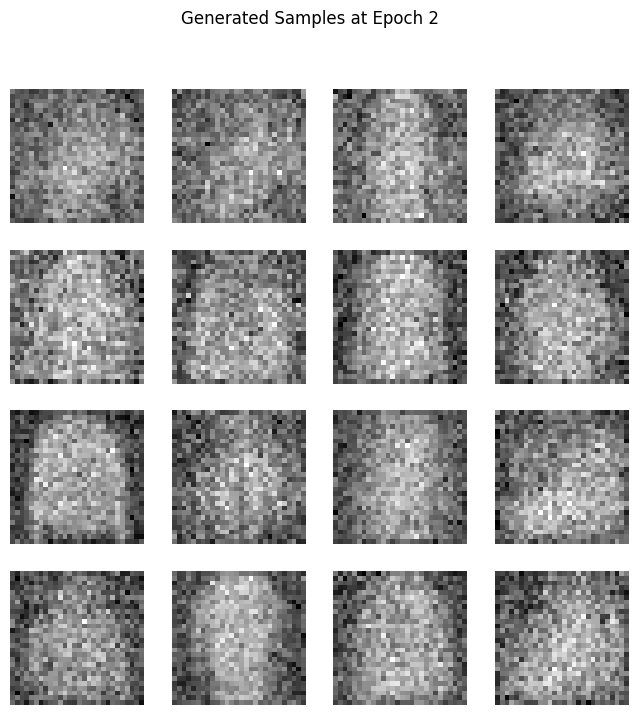

Epoch 3/70 - Training: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


Epoch 3: Train Loss: 758.4030, Val Loss: 754.1991
p_z: 757.7449951171875, log_det_Jac: 0.6580665707588196, norm_loss: 0.0


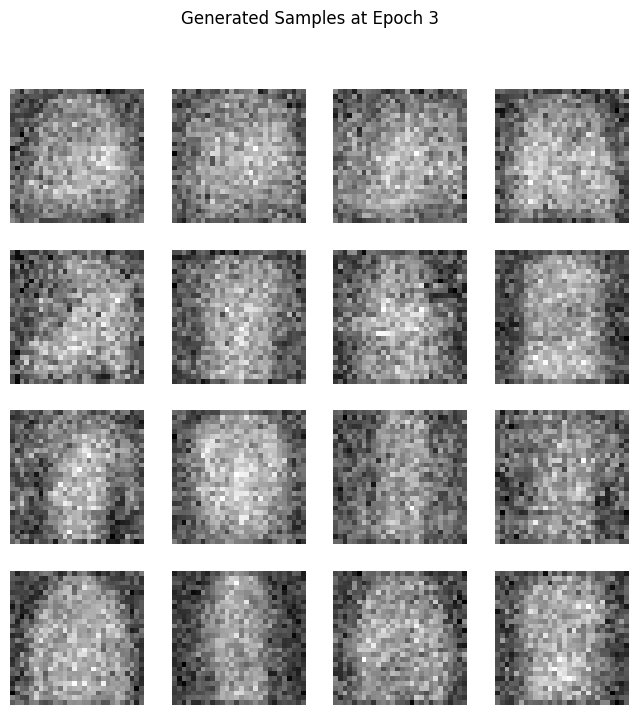

Epoch 4/70 - Training: 100%|██████████| 94/94 [00:38<00:00,  2.44it/s]


Epoch 4: Train Loss: 752.0902, Val Loss: 750.1352
p_z: 752.0807495117188, log_det_Jac: 0.009578848257660866, norm_loss: 0.0


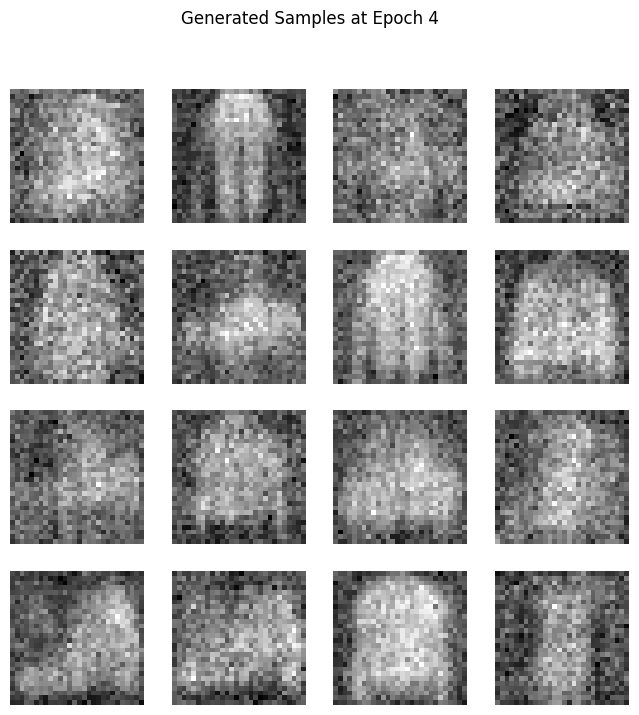

Epoch 5/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 5: Train Loss: 748.7220, Val Loss: 747.3639
p_z: 748.7174682617188, log_det_Jac: 0.0044883135706186295, norm_loss: 0.0


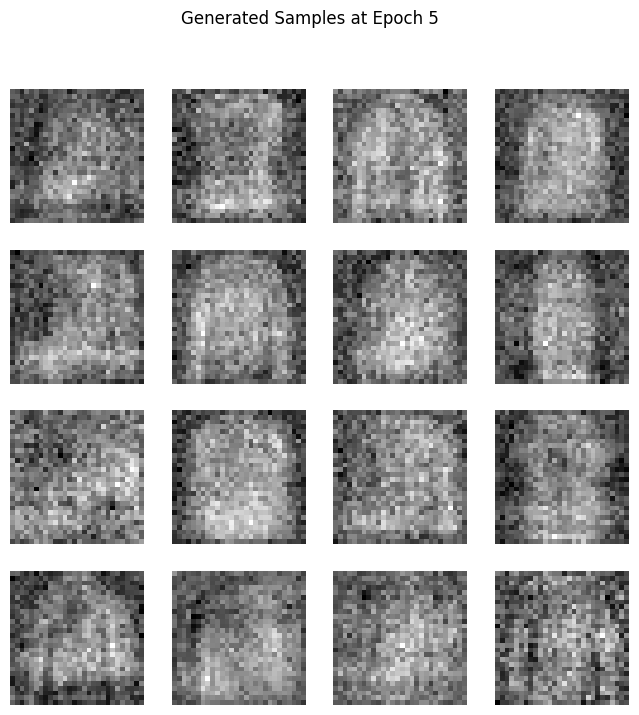

Epoch 6/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 6: Train Loss: 746.3961, Val Loss: 745.4719
p_z: 746.3934936523438, log_det_Jac: 0.002416385104879737, norm_loss: 0.0


Epoch 7/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 7: Train Loss: 744.7245, Val Loss: 744.0089
p_z: 744.7229614257812, log_det_Jac: 0.0014543741708621383, norm_loss: 0.0


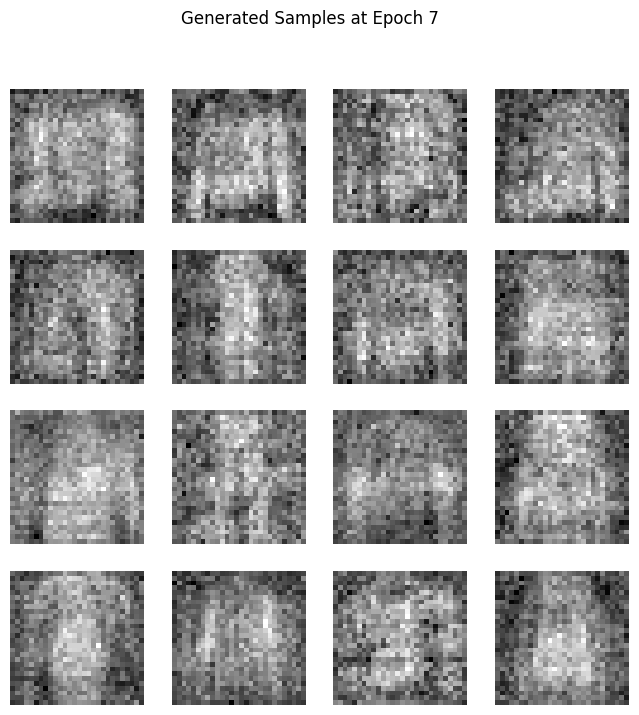

Epoch 8/70 - Training: 100%|██████████| 94/94 [00:38<00:00,  2.41it/s]


Epoch 8: Train Loss: 743.3959, Val Loss: 742.9177
p_z: 743.39501953125, log_det_Jac: 0.0009500040905550122, norm_loss: 0.0


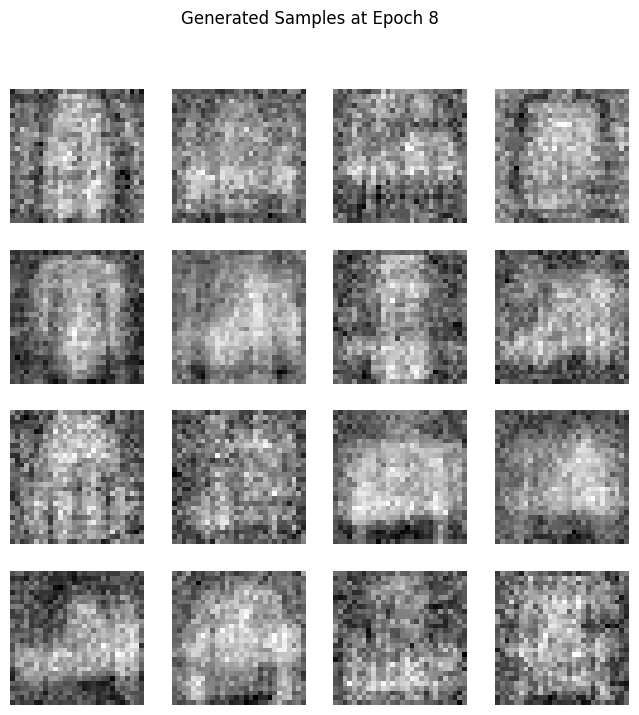

Epoch 9/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 9: Train Loss: 742.3471, Val Loss: 741.9982
p_z: 742.3464965820312, log_det_Jac: 0.0006566358497366309, norm_loss: 0.0


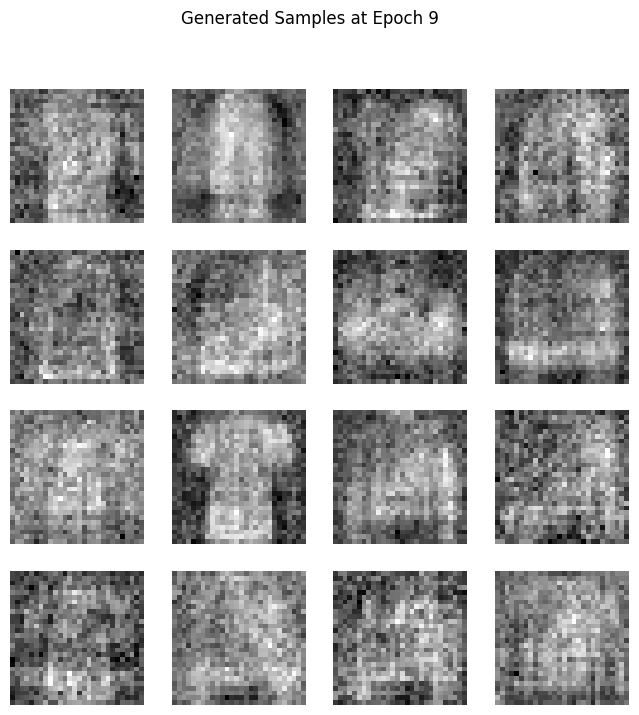

Epoch 10/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.41it/s]


Epoch 10: Train Loss: 741.4633, Val Loss: 741.1870
p_z: 741.4625854492188, log_det_Jac: 0.0004860739572905004, norm_loss: 0.0


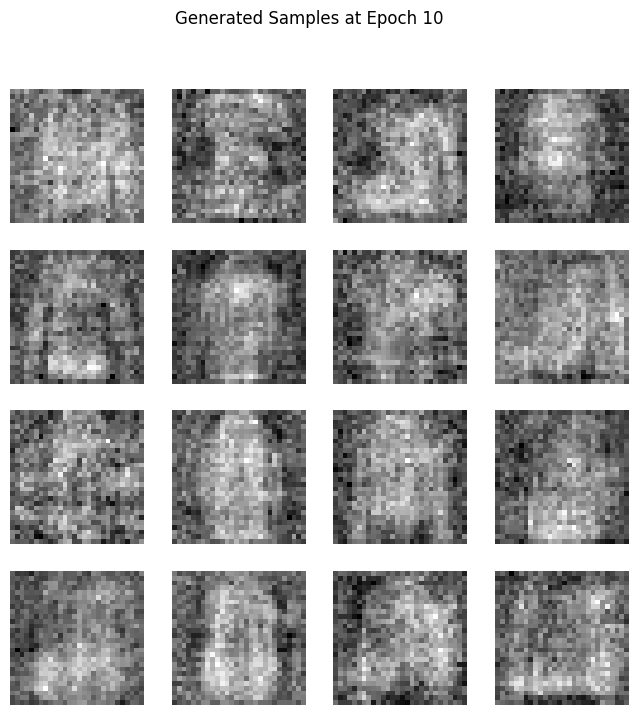

Epoch 11/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 11: Train Loss: 740.7321, Val Loss: 740.5470
p_z: 740.7318725585938, log_det_Jac: 0.00036343434476293623, norm_loss: 0.0


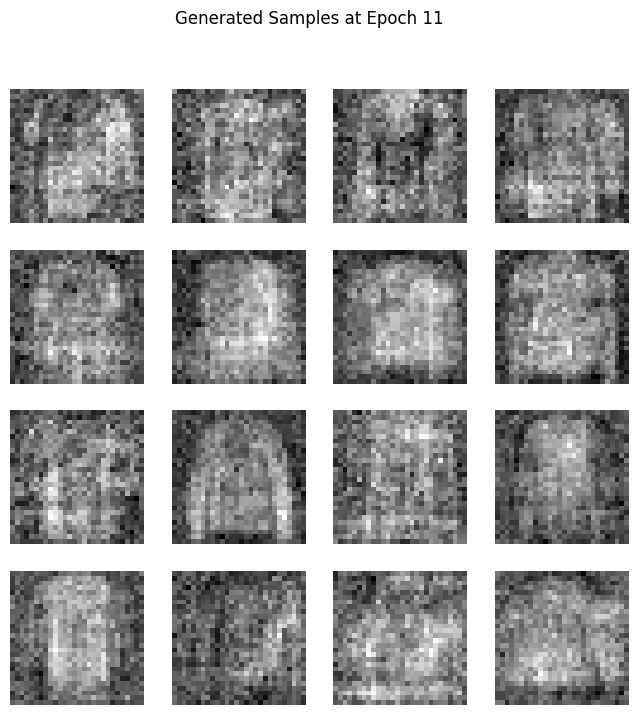

Epoch 12/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 12: Train Loss: 740.0927, Val Loss: 740.0117
p_z: 740.0924072265625, log_det_Jac: 0.0002849125594366342, norm_loss: 0.0


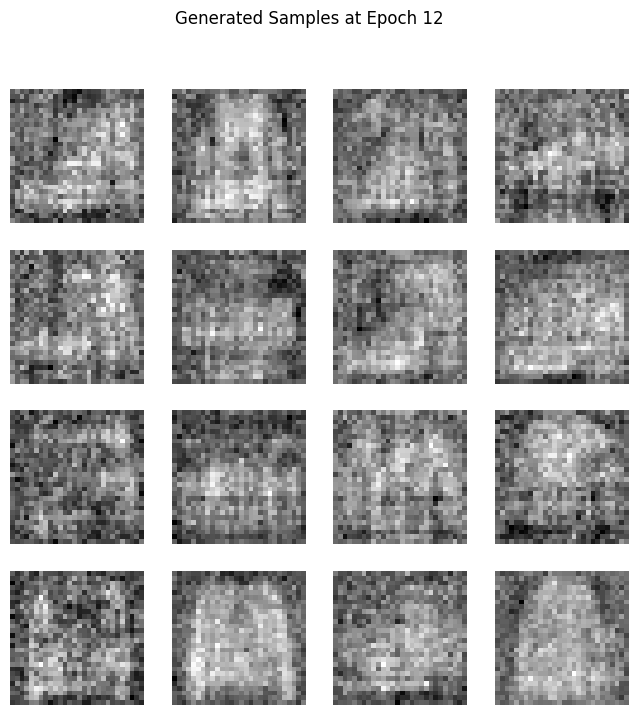

Epoch 13/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 13: Train Loss: 739.5351, Val Loss: 739.5196
p_z: 739.5347290039062, log_det_Jac: 0.00023198108829092234, norm_loss: 0.0


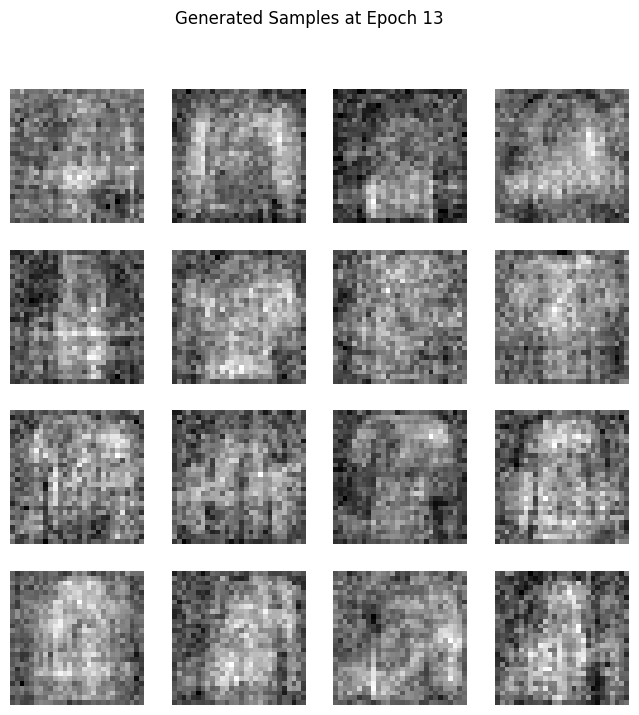

Epoch 14/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 14: Train Loss: 739.0548, Val Loss: 739.0407
p_z: 739.0546875, log_det_Jac: 0.0001883803925011307, norm_loss: 0.0


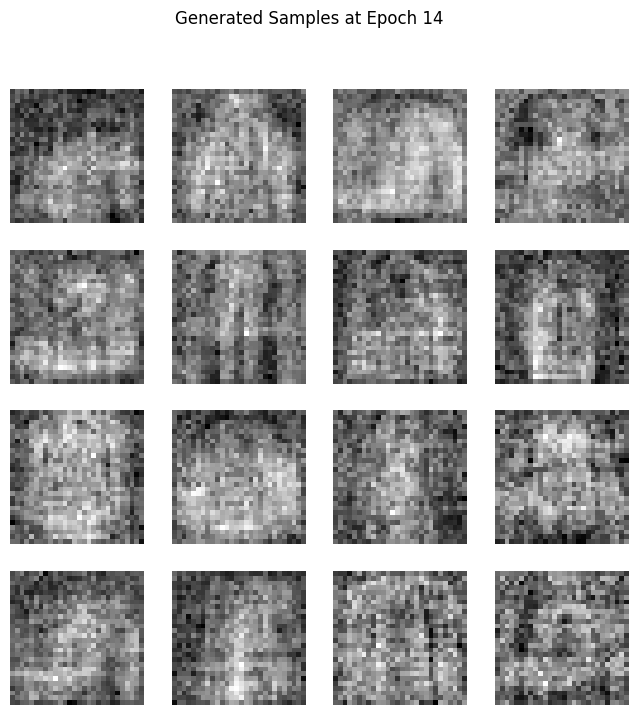

Epoch 15/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 15: Train Loss: 738.6335, Val Loss: 738.6891
p_z: 738.6334838867188, log_det_Jac: 0.0001570040622027591, norm_loss: 0.0


Epoch 16/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 16: Train Loss: 738.2313, Val Loss: 738.2772
p_z: 738.2311401367188, log_det_Jac: 0.00013139999646227807, norm_loss: 0.0


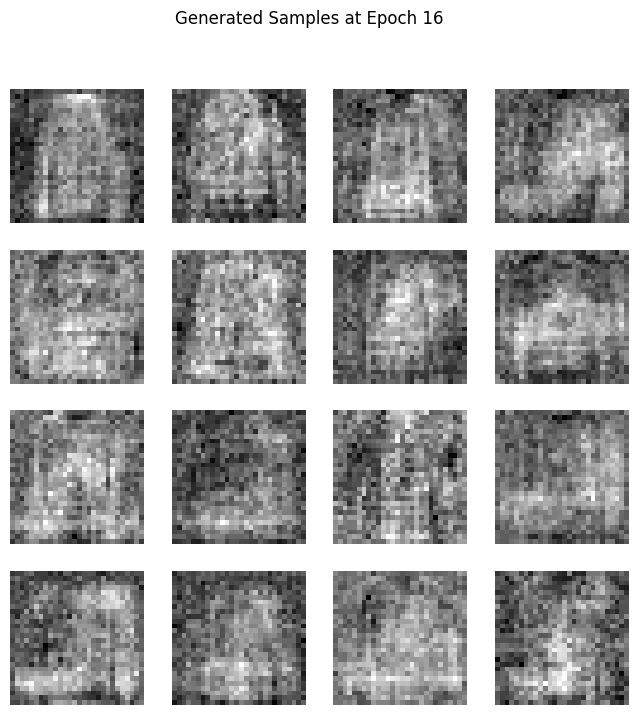

Epoch 17/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 17: Train Loss: 737.8753, Val Loss: 738.0079
p_z: 737.875, log_det_Jac: 0.00011086049198638648, norm_loss: 0.0


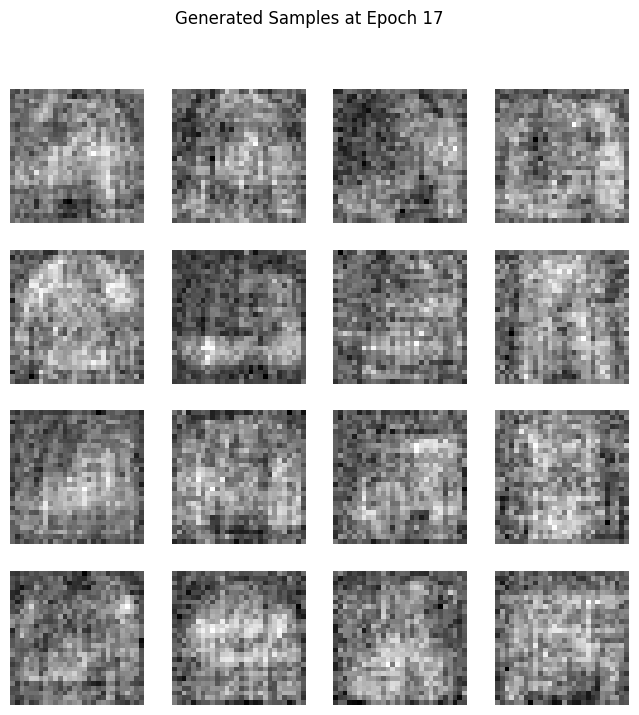

Epoch 18/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 18: Train Loss: 737.5671, Val Loss: 737.6881
p_z: 737.5667724609375, log_det_Jac: 9.656778274802491e-05, norm_loss: 0.0


Epoch 19/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 19: Train Loss: 737.2748, Val Loss: 737.3468
p_z: 737.274658203125, log_det_Jac: 8.402565435972065e-05, norm_loss: 0.0


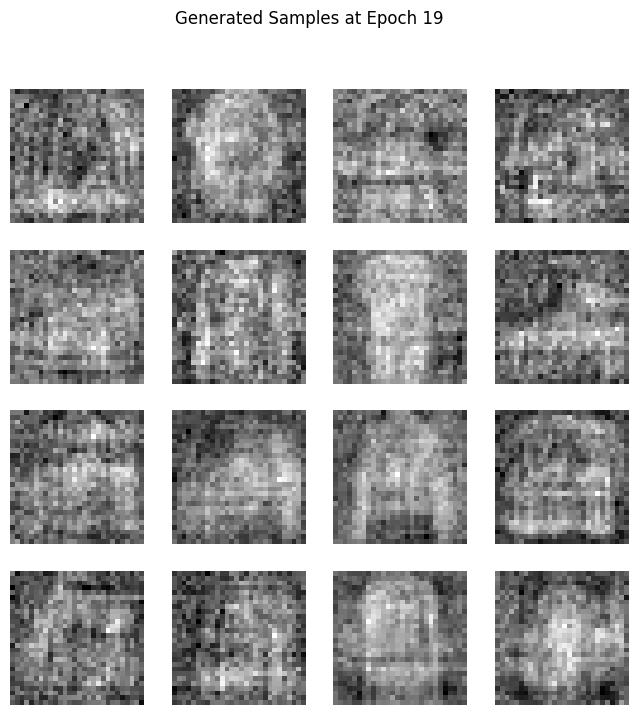

Epoch 20/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 20: Train Loss: 736.9783, Val Loss: 737.1493
p_z: 736.978271484375, log_det_Jac: 7.168832962634042e-05, norm_loss: 0.0


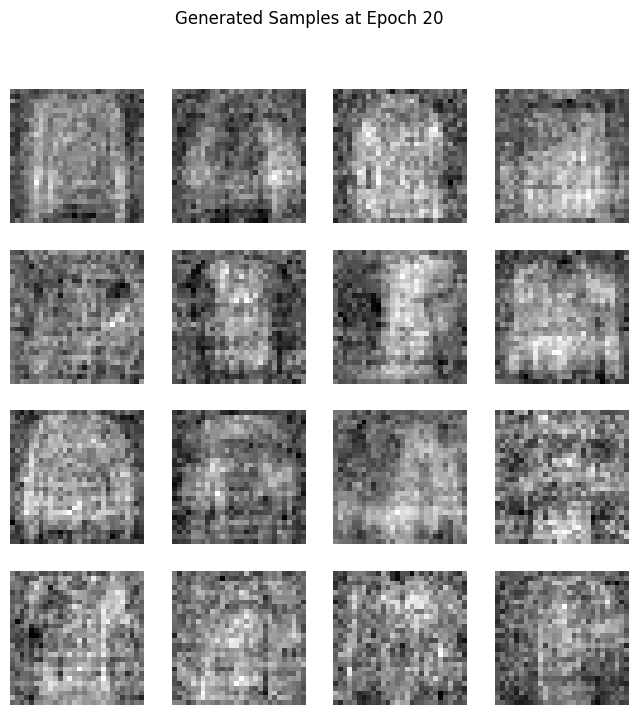

Epoch 21/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 21: Train Loss: 736.7431, Val Loss: 736.9415
p_z: 736.7429809570312, log_det_Jac: 5.952470382908359e-05, norm_loss: 0.0


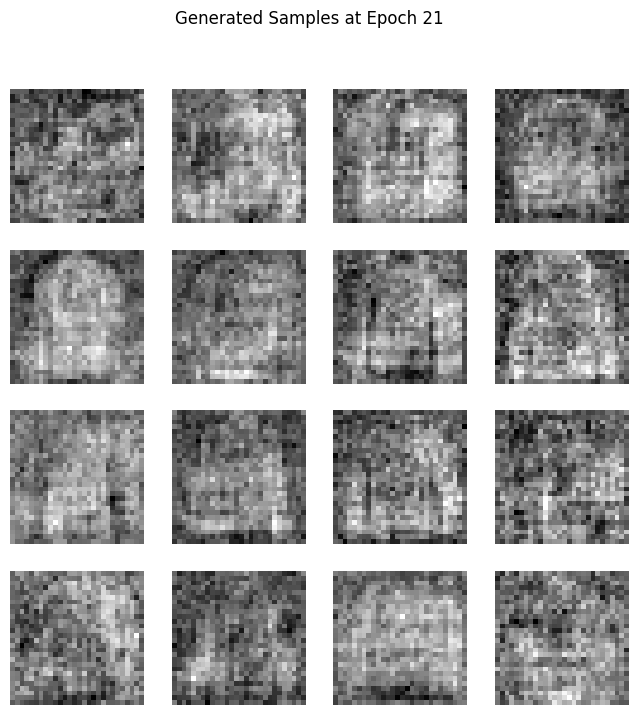

Epoch 22/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 22: Train Loss: 736.4895, Val Loss: 736.7194
p_z: 736.4892578125, log_det_Jac: 5.0523143727332354e-05, norm_loss: 0.0


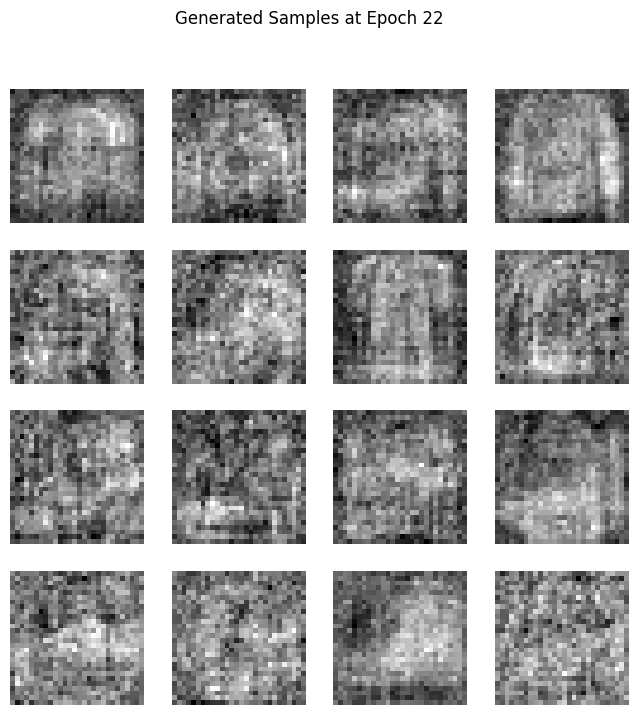

Epoch 23/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 23: Train Loss: 736.2611, Val Loss: 736.5562
p_z: 736.2610473632812, log_det_Jac: 4.189212268101983e-05, norm_loss: 0.0


Epoch 24/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 24: Train Loss: 736.0608, Val Loss: 736.3931
p_z: 736.060791015625, log_det_Jac: 3.538641249178909e-05, norm_loss: 0.0


Epoch 25/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 25: Train Loss: 735.8578, Val Loss: 736.1439
p_z: 735.857666015625, log_det_Jac: 2.9867436751374044e-05, norm_loss: 0.0


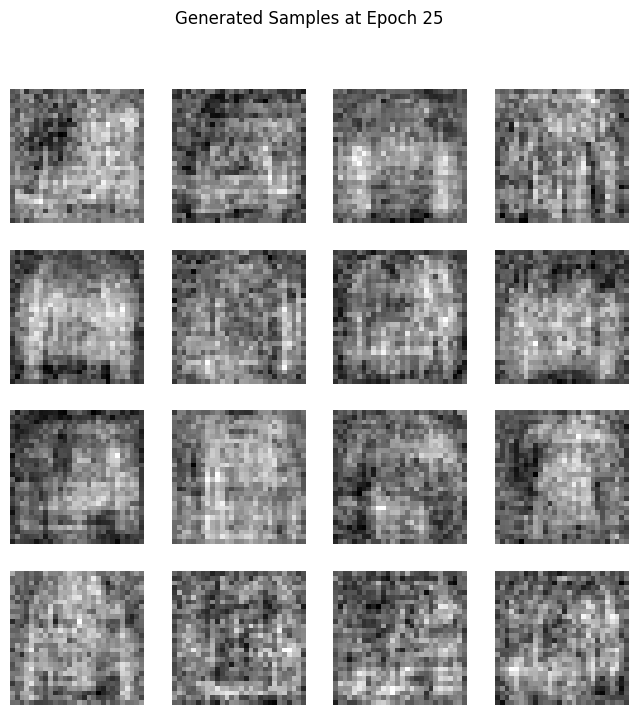

Epoch 26/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 26: Train Loss: 735.6773, Val Loss: 735.9736
p_z: 735.67724609375, log_det_Jac: 2.5457327865296975e-05, norm_loss: 0.0


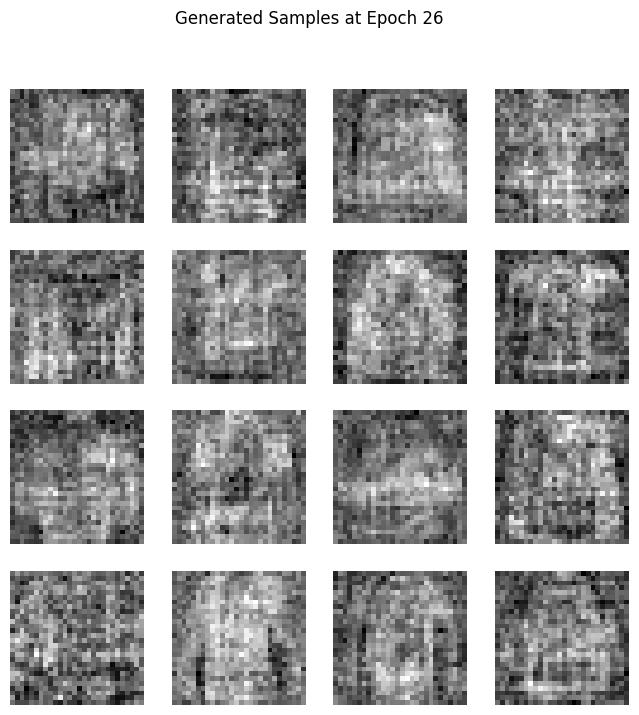

Epoch 27/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 27: Train Loss: 735.4775, Val Loss: 735.7763
p_z: 735.4776000976562, log_det_Jac: 2.2080719645600766e-05, norm_loss: 0.0


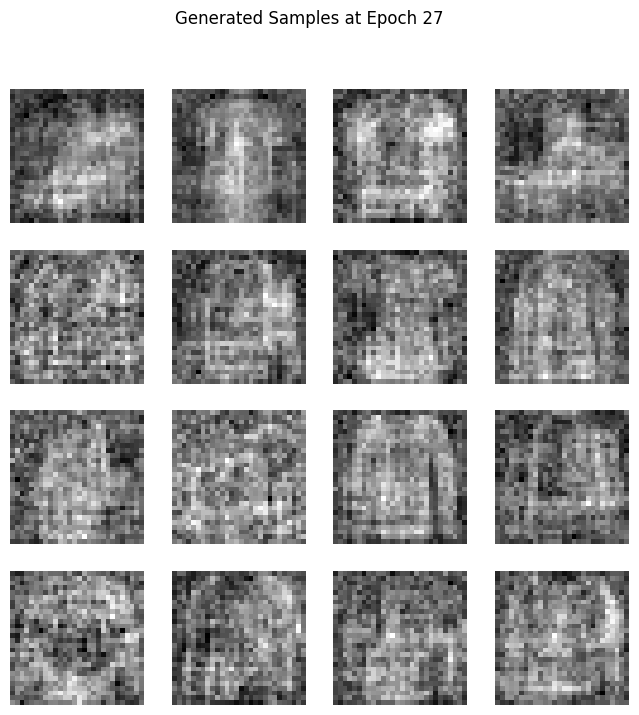

Epoch 28/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 28: Train Loss: 735.3059, Val Loss: 735.6399
p_z: 735.3057250976562, log_det_Jac: 1.8946257114293985e-05, norm_loss: 0.0


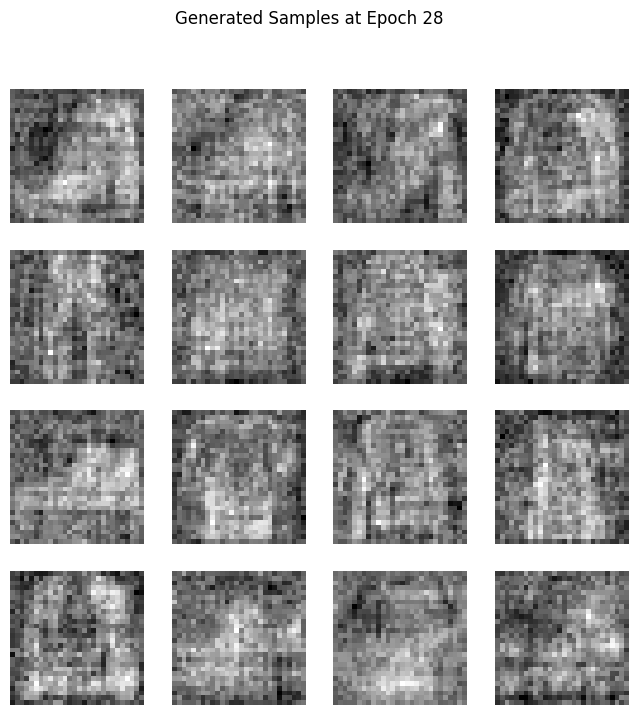

Epoch 29/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 29: Train Loss: 735.1432, Val Loss: 735.4515
p_z: 735.1432495117188, log_det_Jac: 1.644533040234819e-05, norm_loss: 0.0


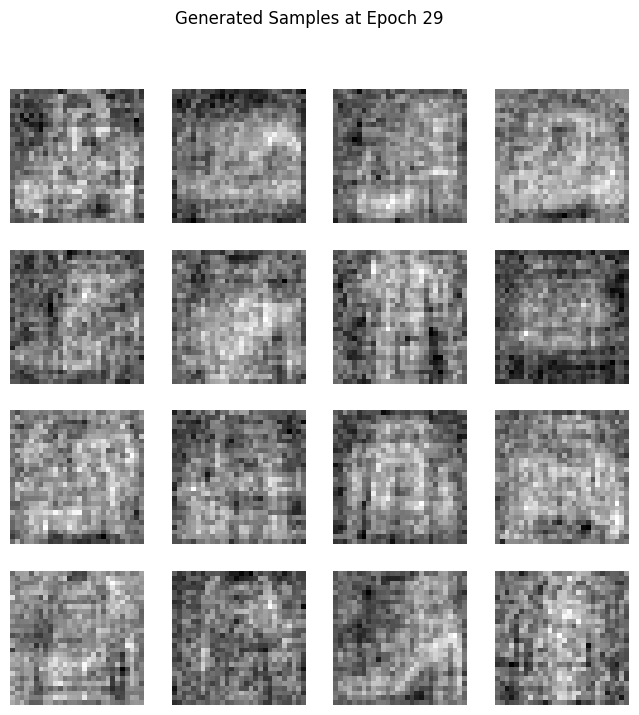

Epoch 30/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 30: Train Loss: 734.9866, Val Loss: 735.3450
p_z: 734.9864501953125, log_det_Jac: 1.4235802154871635e-05, norm_loss: 0.0


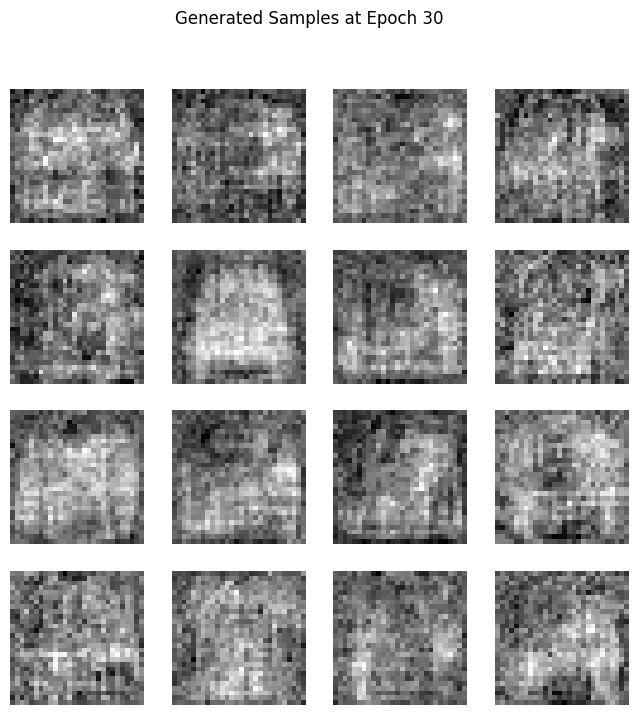

Epoch 31/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 31: Train Loss: 734.8157, Val Loss: 735.2595
p_z: 734.8155517578125, log_det_Jac: 1.1854300282720942e-05, norm_loss: 0.0


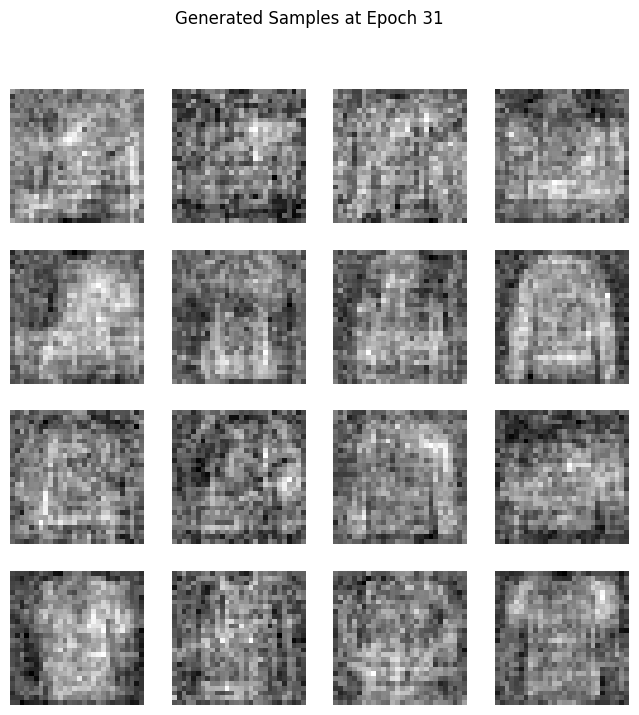

Epoch 32/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 32: Train Loss: 734.6576, Val Loss: 735.0648
p_z: 734.657470703125, log_det_Jac: 1.0197608389717061e-05, norm_loss: 0.0


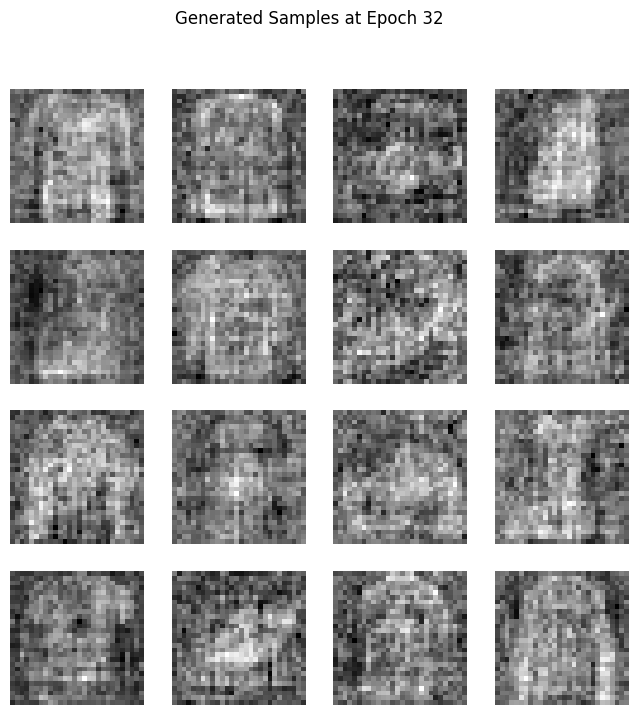

Epoch 33/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]


Epoch 33: Train Loss: 734.5059, Val Loss: 734.9534
p_z: 734.5057983398438, log_det_Jac: 8.99705173651455e-06, norm_loss: 0.0


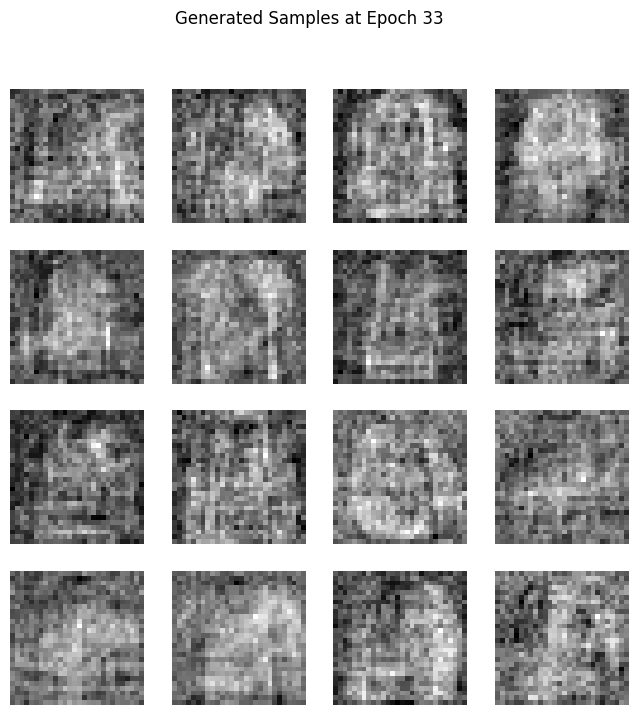

Epoch 34/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 34: Train Loss: 734.3668, Val Loss: 734.7978
p_z: 734.3665771484375, log_det_Jac: 7.836073564249091e-06, norm_loss: 0.0


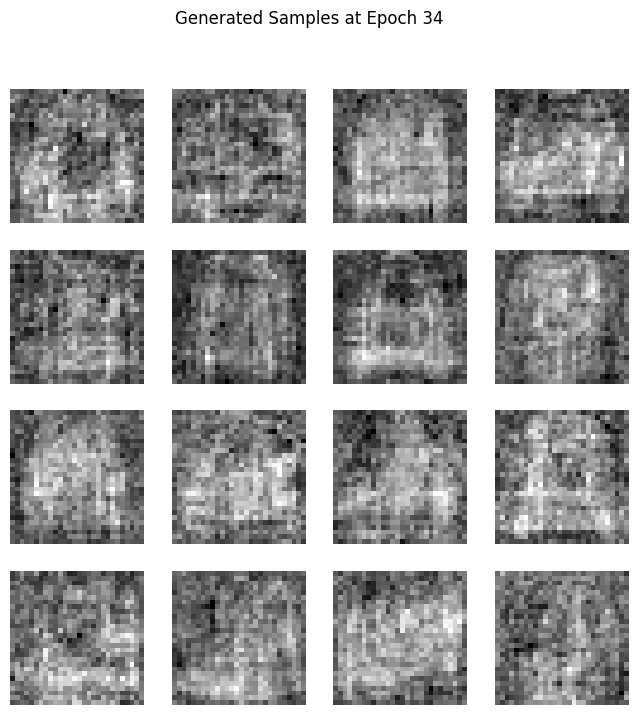

Epoch 35/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 35: Train Loss: 734.2244, Val Loss: 734.6684
p_z: 734.2243041992188, log_det_Jac: 7.281604212039383e-06, norm_loss: 0.0


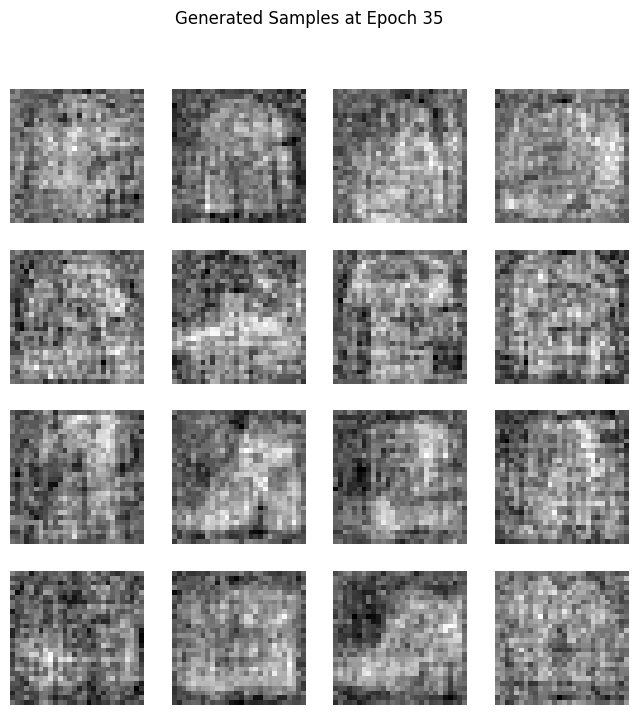

Epoch 36/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 36: Train Loss: 734.0765, Val Loss: 734.5843
p_z: 734.0763549804688, log_det_Jac: 6.291850240813801e-06, norm_loss: 0.0


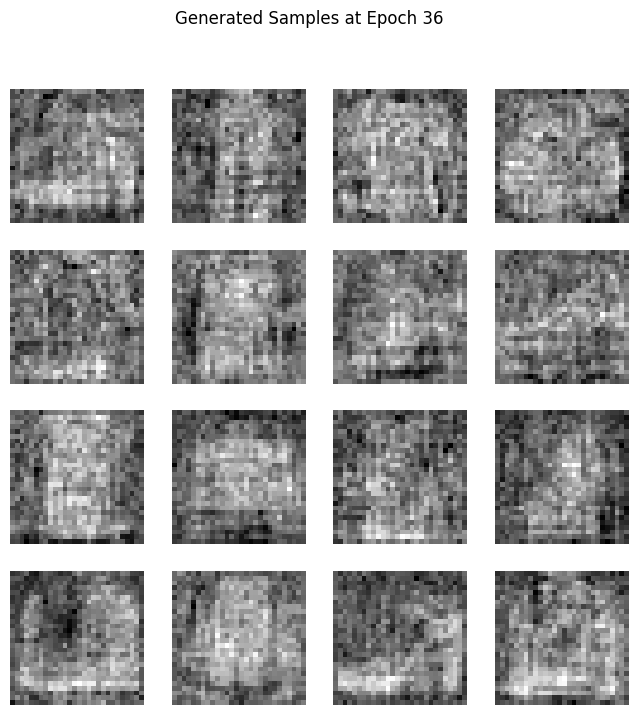

Epoch 37/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]


Epoch 37: Train Loss: 733.9990, Val Loss: 734.4489
p_z: 733.9989624023438, log_det_Jac: 6.150716671982082e-06, norm_loss: 0.0


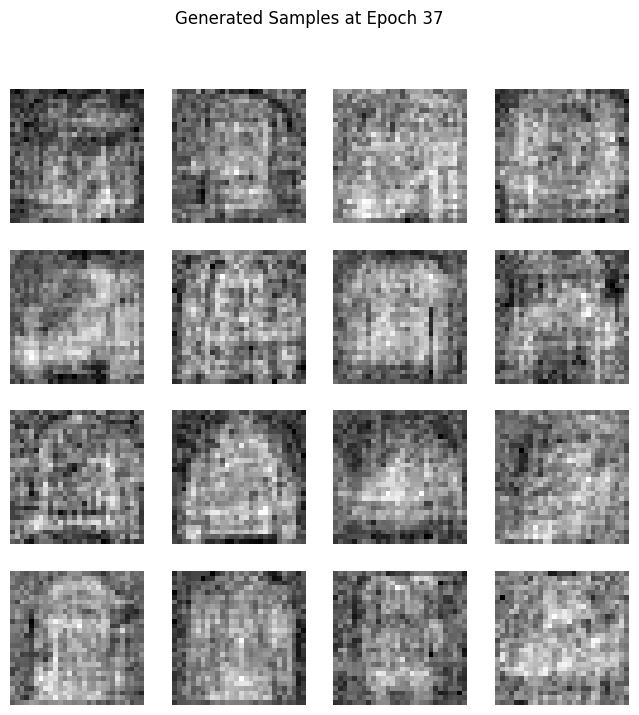

Epoch 38/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 38: Train Loss: 733.8045, Val Loss: 734.2868
p_z: 733.8045043945312, log_det_Jac: 4.787194029631792e-06, norm_loss: 0.0


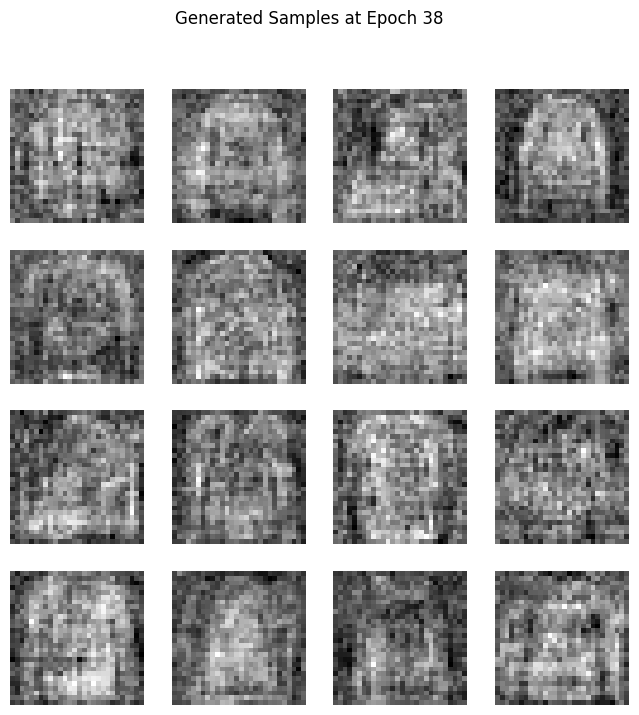

Epoch 39/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]


Epoch 39: Train Loss: 733.6880, Val Loss: 734.2862
p_z: 733.68798828125, log_det_Jac: 3.863327037834097e-06, norm_loss: 0.0


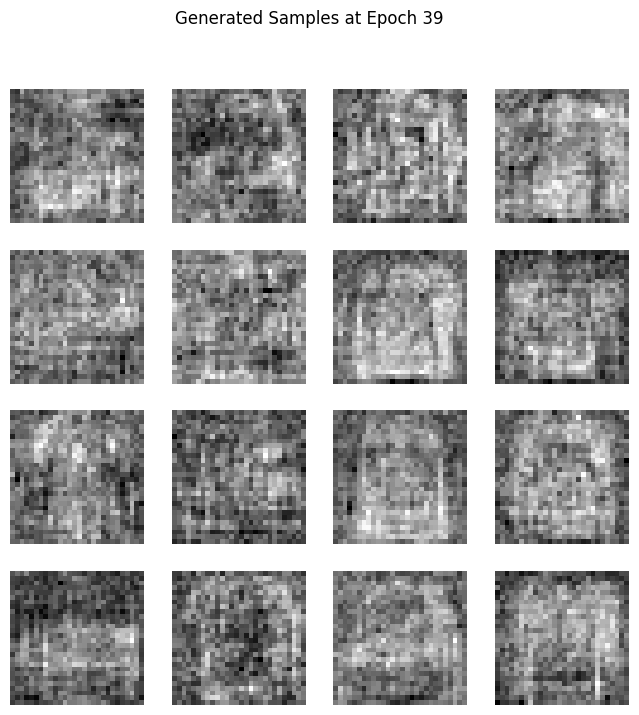

Epoch 40/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 40: Train Loss: 733.5868, Val Loss: 734.1388
p_z: 733.5868530273438, log_det_Jac: 3.402982656552922e-06, norm_loss: 0.0


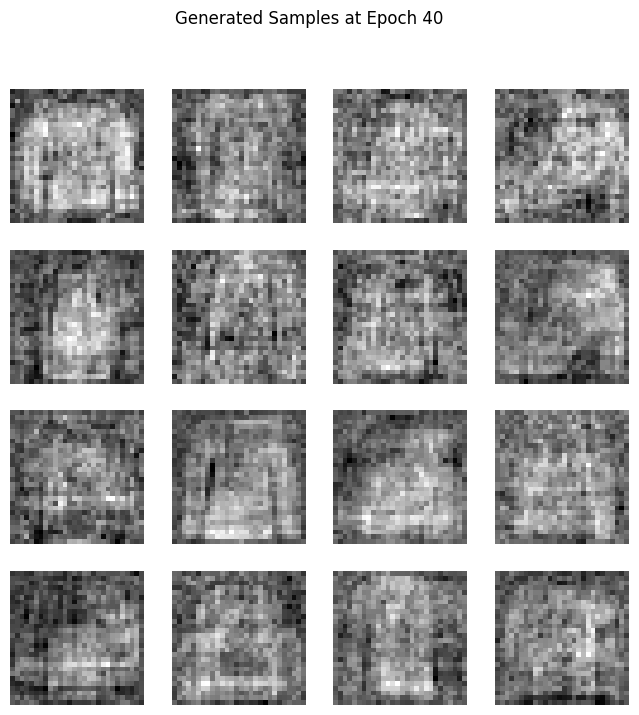

Epoch 41/70 - Training: 100%|██████████| 94/94 [00:40<00:00,  2.34it/s]


Epoch 41: Train Loss: 733.4296, Val Loss: 733.9481
p_z: 733.429443359375, log_det_Jac: 2.8591980480996426e-06, norm_loss: 0.0


Epoch 42/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 42: Train Loss: 733.3185, Val Loss: 733.8564
p_z: 733.3185424804688, log_det_Jac: 2.550514636823209e-06, norm_loss: 0.0


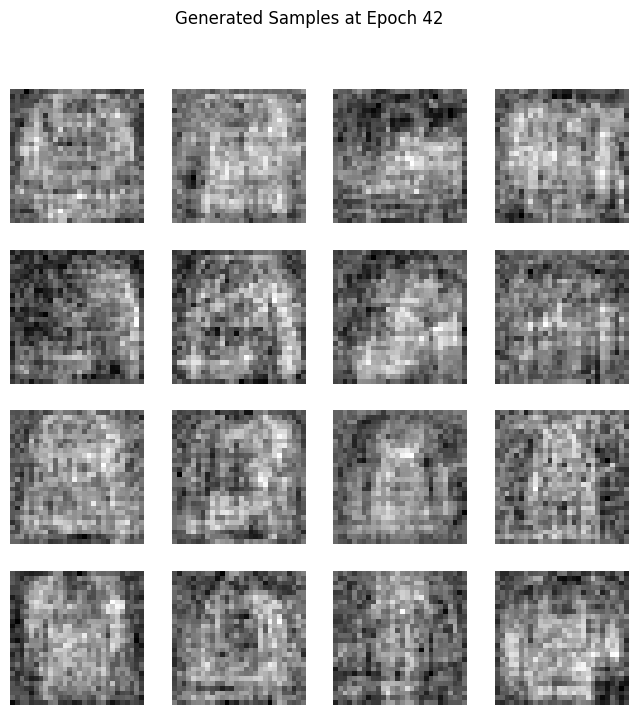

Epoch 43/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 43: Train Loss: 733.1910, Val Loss: 733.7094
p_z: 733.1907958984375, log_det_Jac: 2.3795173547114246e-06, norm_loss: 0.0


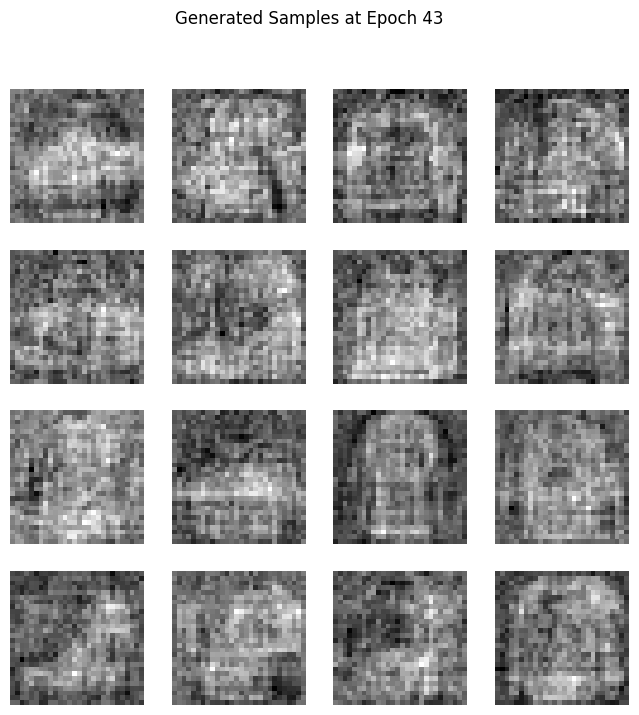

Epoch 44/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 44: Train Loss: 733.0499, Val Loss: 733.6332
p_z: 733.0499267578125, log_det_Jac: 2.051711817330215e-06, norm_loss: 0.0


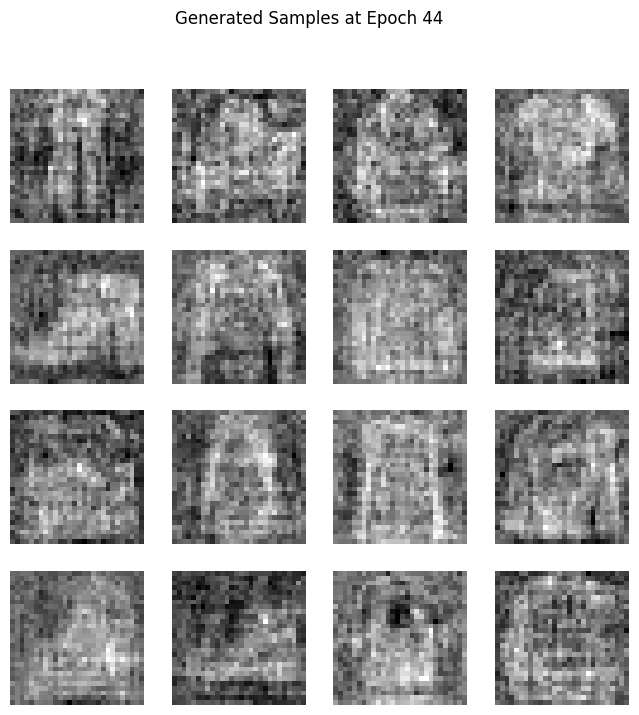

Epoch 45/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 45: Train Loss: 732.9667, Val Loss: 733.8010
p_z: 732.966552734375, log_det_Jac: 2.022545231739059e-06, norm_loss: 0.0


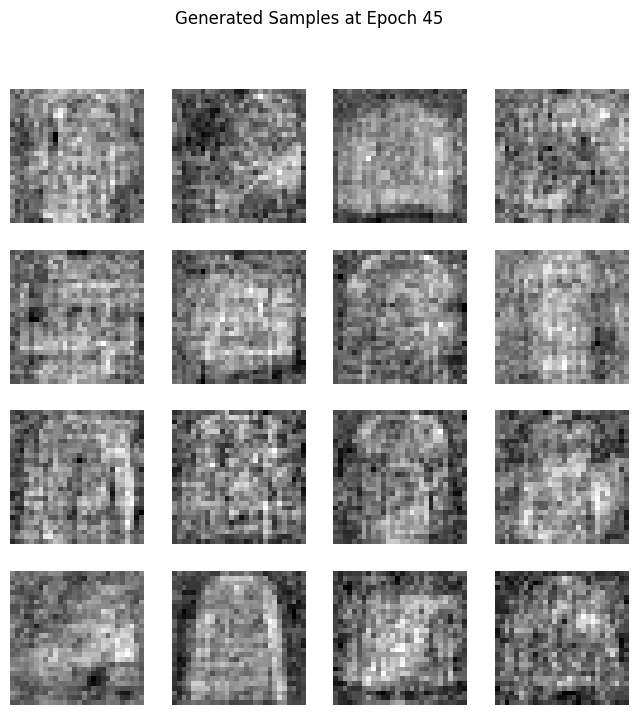

Epoch 46/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 46: Train Loss: 732.8834, Val Loss: 733.5194
p_z: 732.8833618164062, log_det_Jac: 1.993350906559499e-06, norm_loss: 0.0


Epoch 47/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 47: Train Loss: 732.7133, Val Loss: 733.4280
p_z: 732.713134765625, log_det_Jac: 1.7470829334342852e-06, norm_loss: 0.0


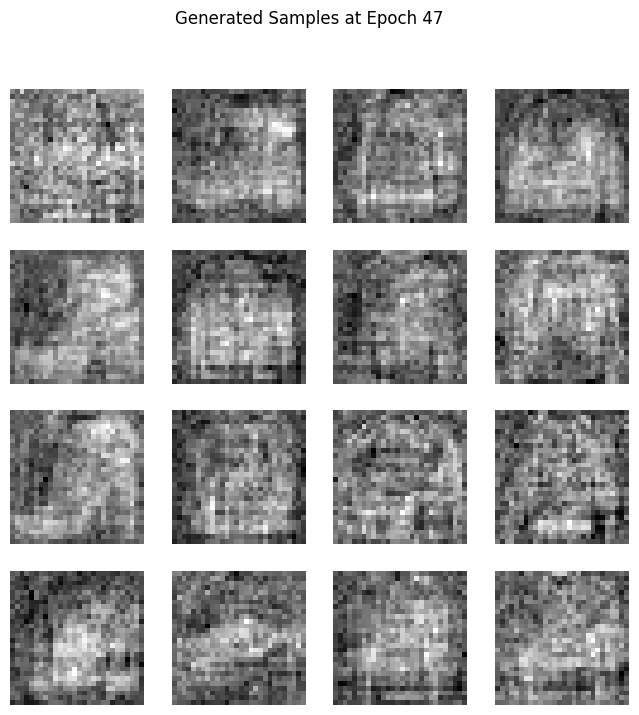

Epoch 48/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 48: Train Loss: 732.6069, Val Loss: 733.2728
p_z: 732.6068725585938, log_det_Jac: 1.5018376871012151e-06, norm_loss: 0.0


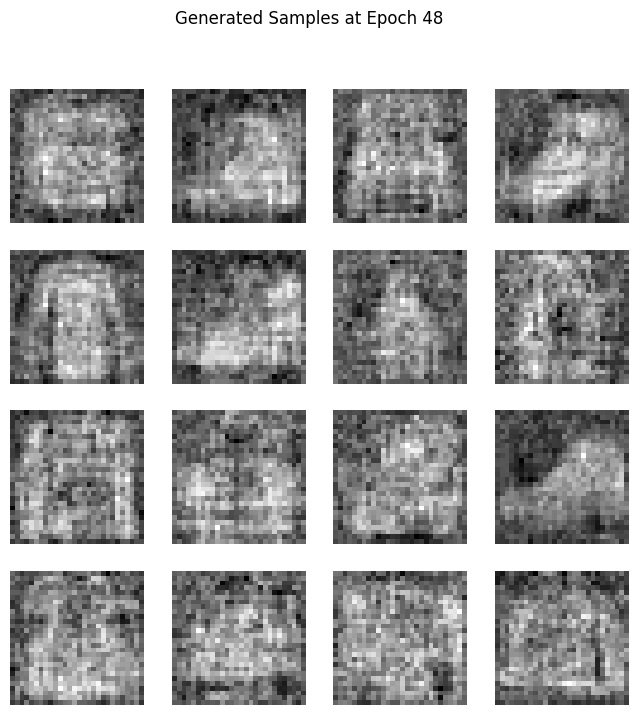

Epoch 49/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 49: Train Loss: 732.5929, Val Loss: 733.2021
p_z: 732.5928955078125, log_det_Jac: 1.4751085473108105e-06, norm_loss: 0.0


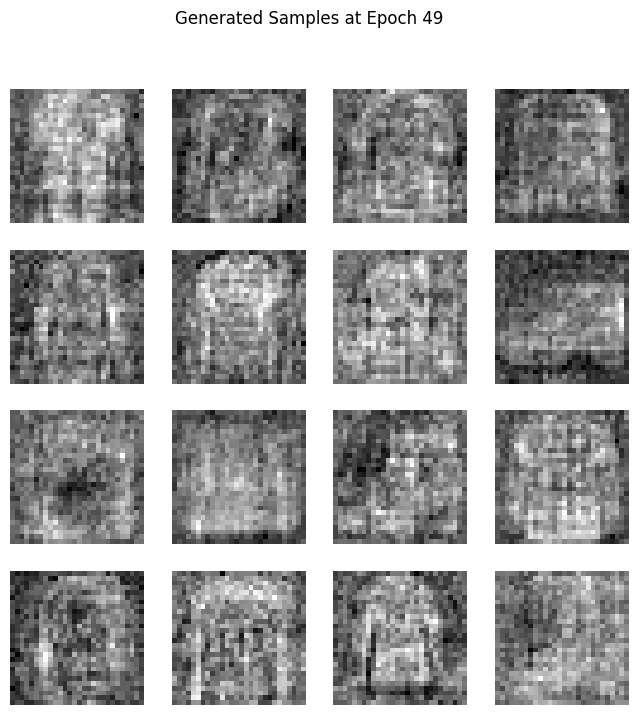

Epoch 50/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.40it/s]


Epoch 50: Train Loss: 732.3777, Val Loss: 733.0756
p_z: 732.3778076171875, log_det_Jac: 1.1504115491334233e-06, norm_loss: 0.0


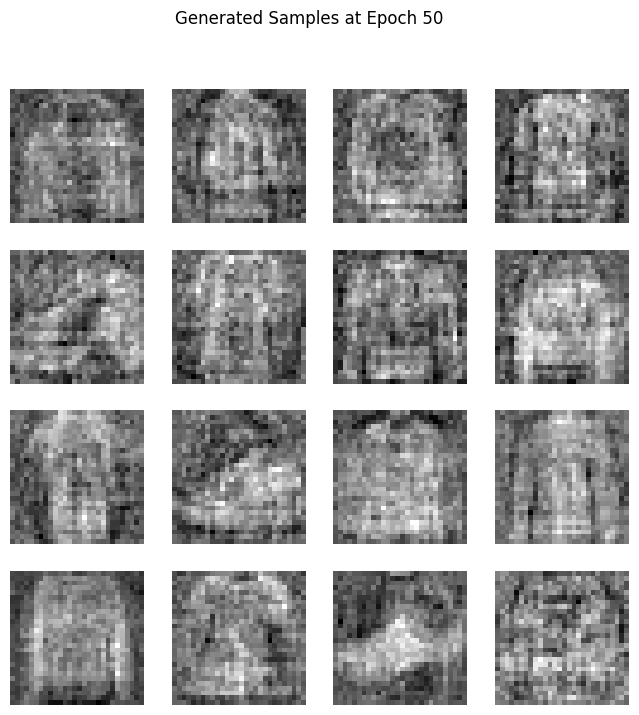

Epoch 51/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 51: Train Loss: 732.2891, Val Loss: 733.2044
p_z: 732.2891845703125, log_det_Jac: 1.038593154589762e-06, norm_loss: 0.0


Epoch 52/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 52: Train Loss: 732.2121, Val Loss: 733.1071
p_z: 732.2120971679688, log_det_Jac: 1.0213516361545771e-06, norm_loss: 0.0


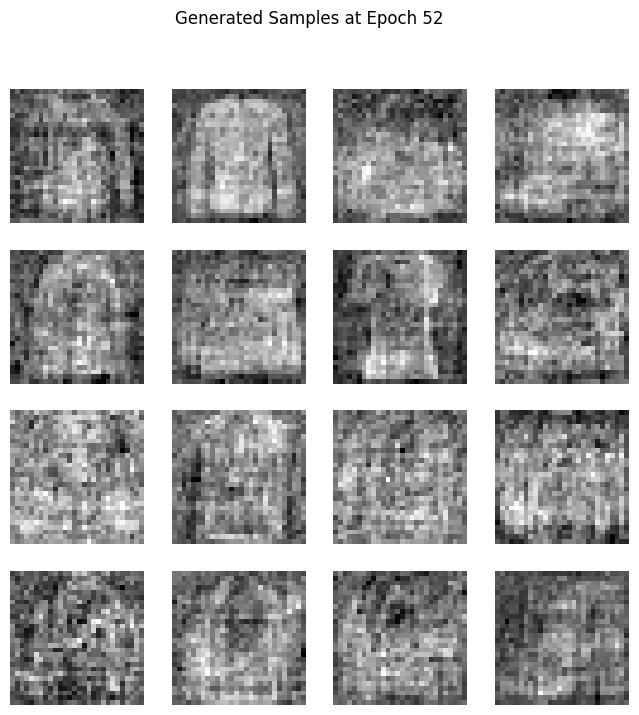

Epoch 53/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 53: Train Loss: 732.0766, Val Loss: 732.8632
p_z: 732.0767822265625, log_det_Jac: 9.205302831105655e-07, norm_loss: 0.0


Epoch 54/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 54: Train Loss: 731.9718, Val Loss: 732.8015
p_z: 731.9717407226562, log_det_Jac: 8.532548463335843e-07, norm_loss: 0.0


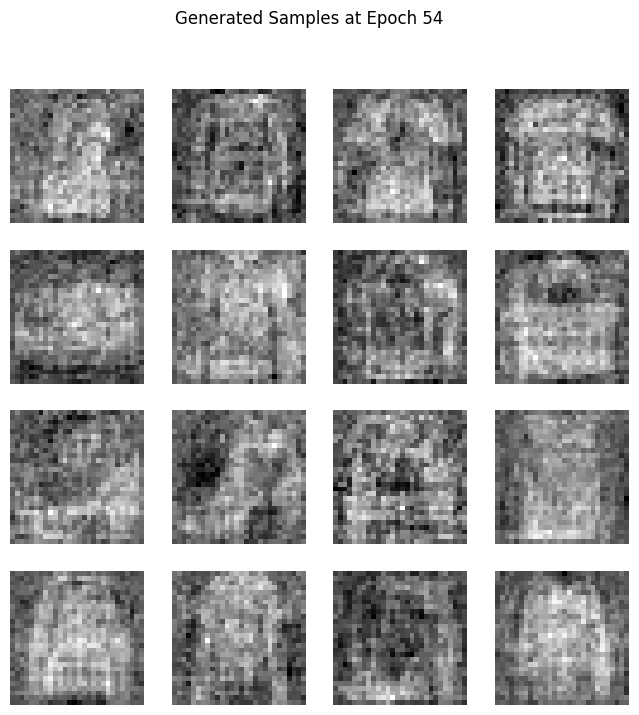

Epoch 55/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 55: Train Loss: 731.9654, Val Loss: 732.7649
p_z: 731.96533203125, log_det_Jac: 9.065514063877345e-07, norm_loss: 0.0


Epoch 56/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 56: Train Loss: 731.8584, Val Loss: 732.6416
p_z: 731.8582763671875, log_det_Jac: 8.798825206213223e-07, norm_loss: 0.0


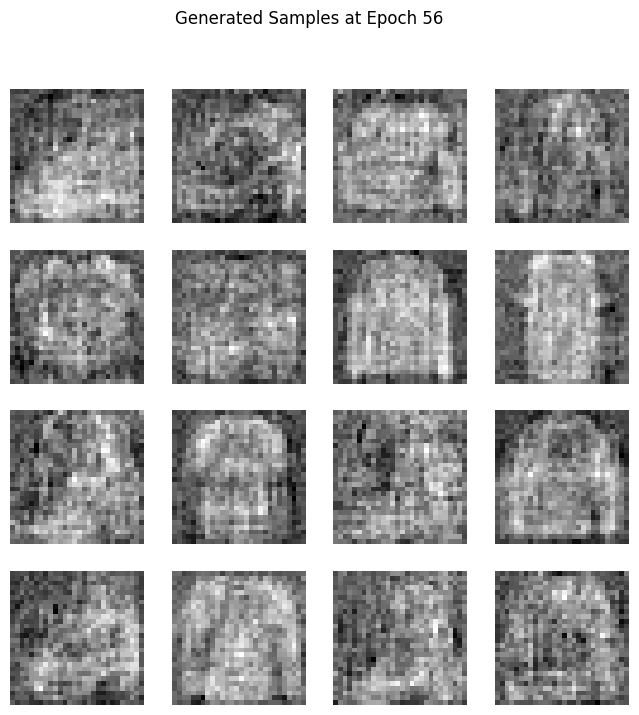

Epoch 57/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 57: Train Loss: 731.7611, Val Loss: 732.8634
p_z: 731.7611083984375, log_det_Jac: 8.065034080573241e-07, norm_loss: 0.0


Epoch 58/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 58: Train Loss: 731.5828, Val Loss: 732.4471
p_z: 731.5825805664062, log_det_Jac: 6.517208248624229e-07, norm_loss: 0.0


Epoch 59/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 59: Train Loss: 731.4386, Val Loss: 732.4495
p_z: 731.4386596679688, log_det_Jac: 4.865859750680102e-07, norm_loss: 0.0


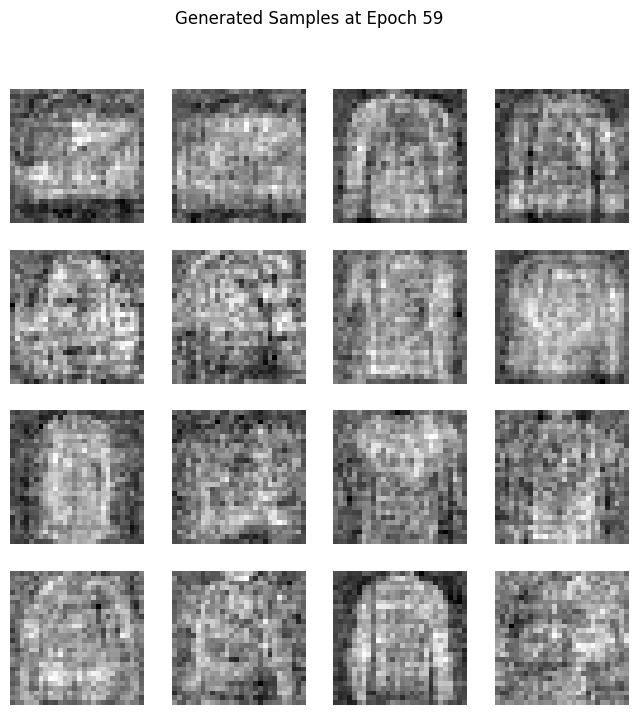

Epoch 60/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 60: Train Loss: 731.3967, Val Loss: 732.2947
p_z: 731.3968505859375, log_det_Jac: 4.629337695405411e-07, norm_loss: 0.0


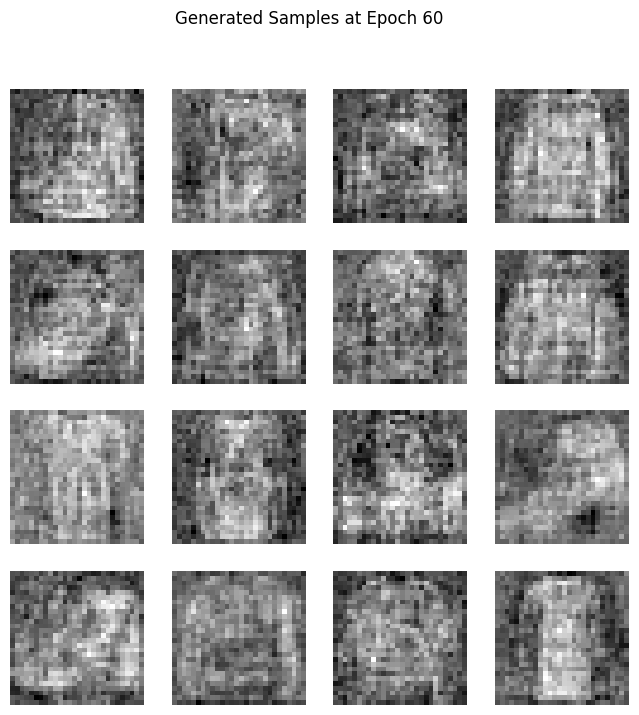

Epoch 61/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 61: Train Loss: 731.3013, Val Loss: 732.1509
p_z: 731.30126953125, log_det_Jac: 4.118147103326919e-07, norm_loss: 0.0


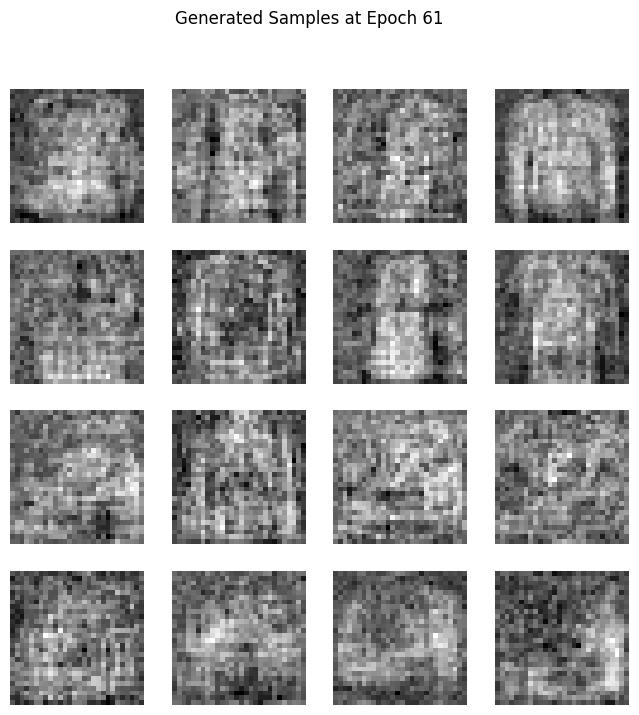

Epoch 62/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 62: Train Loss: 731.2054, Val Loss: 732.1327
p_z: 731.205322265625, log_det_Jac: 3.7819293652319175e-07, norm_loss: 0.0


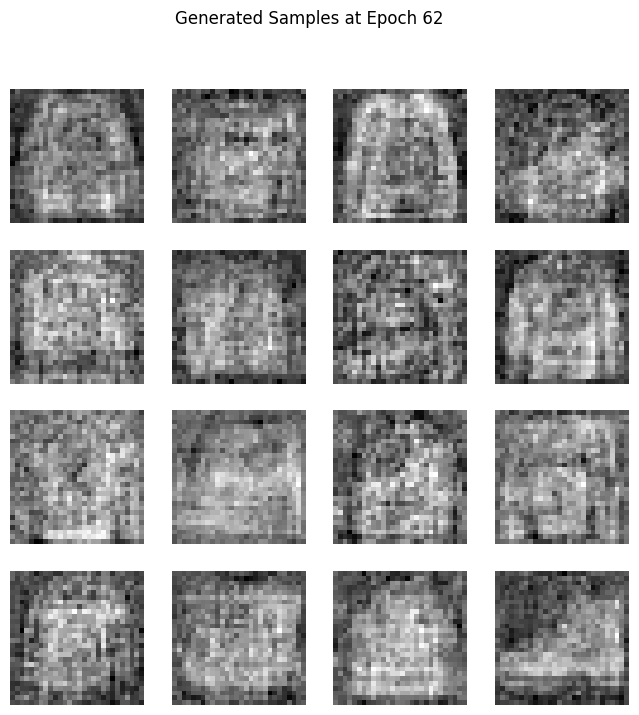

Epoch 63/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 63: Train Loss: 731.1219, Val Loss: 732.1827
p_z: 731.1218872070312, log_det_Jac: 3.687102605454129e-07, norm_loss: 0.0


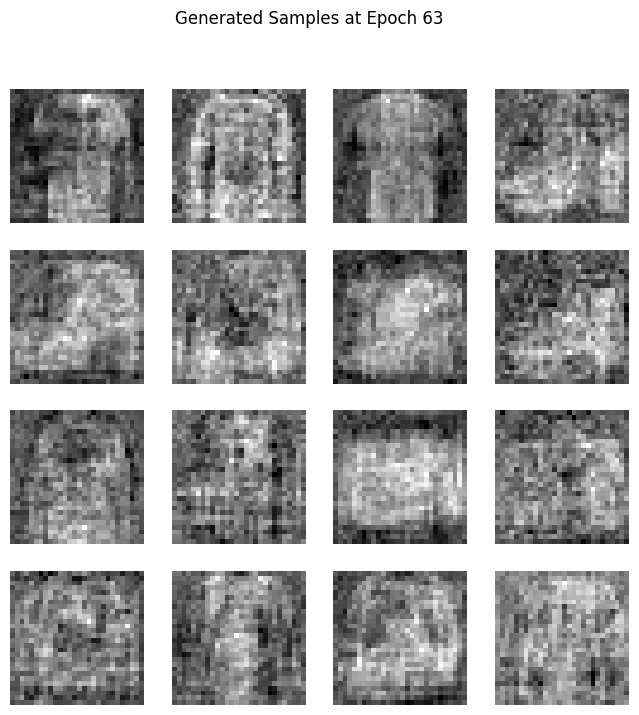

Epoch 64/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 64: Train Loss: 731.0165, Val Loss: 732.1300
p_z: 731.0166015625, log_det_Jac: 3.494909321943851e-07, norm_loss: 0.0


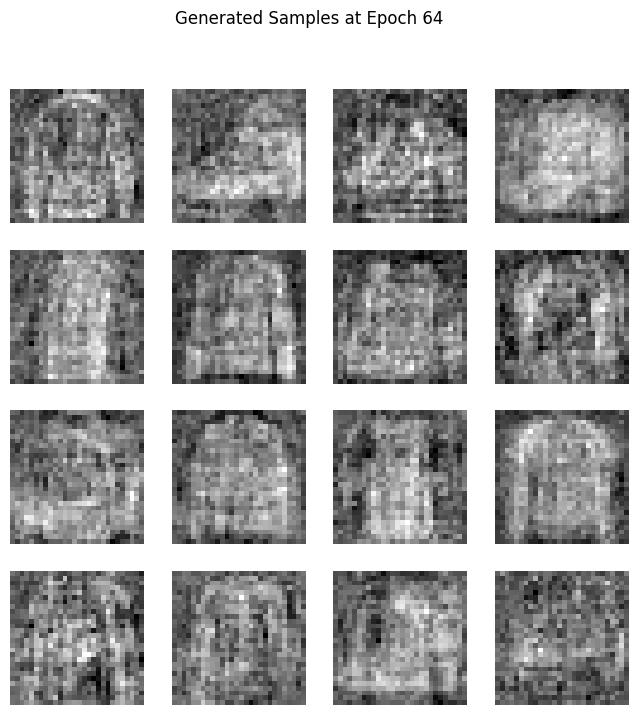

Epoch 65/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 65: Train Loss: 730.9394, Val Loss: 732.1840
p_z: 730.9393310546875, log_det_Jac: 3.2478268963131995e-07, norm_loss: 0.0


Epoch 66/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.37it/s]


Epoch 66: Train Loss: 730.8425, Val Loss: 731.8716
p_z: 730.8424682617188, log_det_Jac: 3.074013932291564e-07, norm_loss: 0.0


Epoch 67/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Epoch 67: Train Loss: 730.7588, Val Loss: 731.7401
p_z: 730.7588500976562, log_det_Jac: 2.98349362992667e-07, norm_loss: 0.0


Epoch 68/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Epoch 68: Train Loss: 730.6897, Val Loss: 731.8406
p_z: 730.6896362304688, log_det_Jac: 2.8330020995781524e-07, norm_loss: 0.0


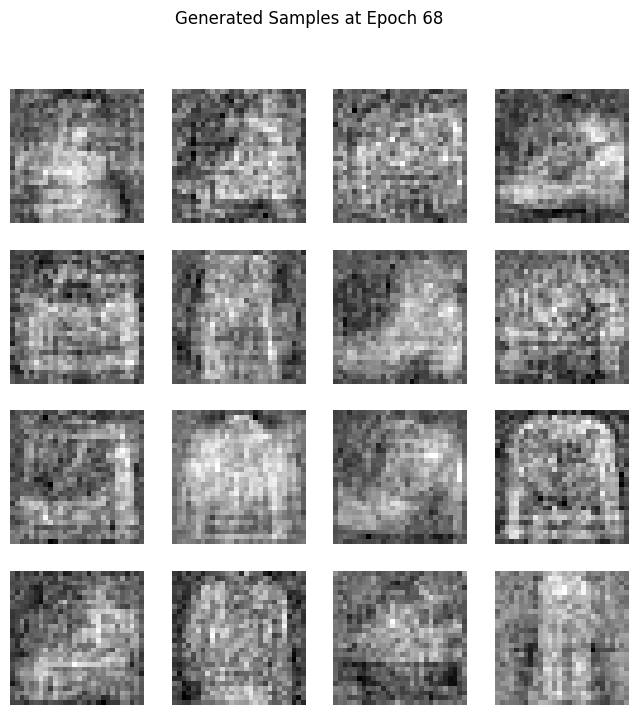

Epoch 69/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.35it/s]


Epoch 69: Train Loss: 730.5979, Val Loss: 731.6118
p_z: 730.597900390625, log_det_Jac: 2.654940942647954e-07, norm_loss: 0.0


Epoch 70/70 - Training: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Epoch 70: Train Loss: 730.5406, Val Loss: 731.6726
p_z: 730.5407104492188, log_det_Jac: 2.5829953642642067e-07, norm_loss: 0.0


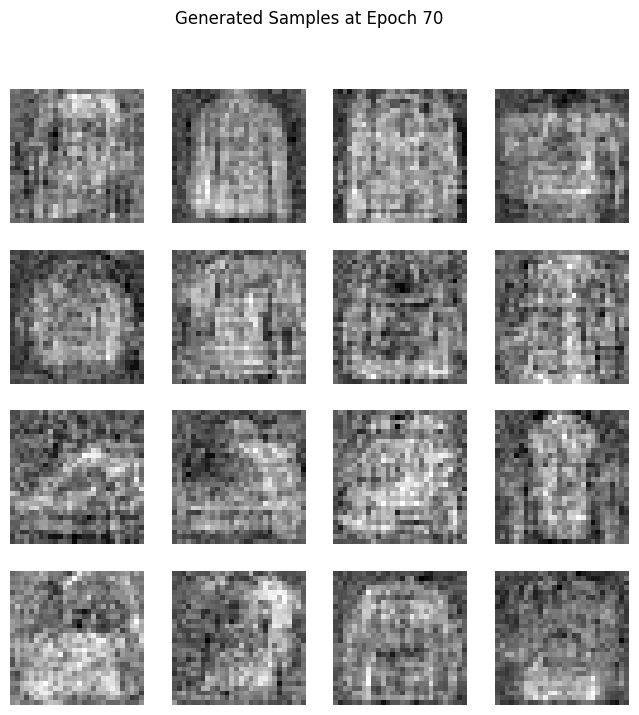

In [8]:
realnvp.train_realnvp(train_loader, val_loader, epochs=70, optimizer=optimizer, device=device)


In [14]:
def demonstrate_x(model, test_loader, device):
    model.eval()
    batch = next(iter(test_loader))
    x, _ = batch
    x = x.view(x.size(0), -1).to(device)

    with torch.no_grad():
        z, _, _ = model.forward(x)
        recon_x = model.backward(z).view(-1, 28, 28).cpu().numpy()

    # Display 9 random original and reconstructed images
    plt.figure(figsize=(10, 5))
    for i in range(9):
        idx = np.random.randint(0, x.size(0))
        plt.subplot(3, 6, i * 2 + 1)
        plt.imshow(x[idx].view(28, 28).cpu().numpy(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(3, 6, i * 2 + 2)
        plt.imshow(recon_x[idx], cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

        print(sum(sum(x[i].view(28, 28).cpu().numpy()-recon_x[i])))

    plt.tight_layout()
    plt.show()

In [10]:
sample_images = []
x = realnvp.sample(16).cpu().detach().view(-1,28,28).numpy()
sample_images.append(x)

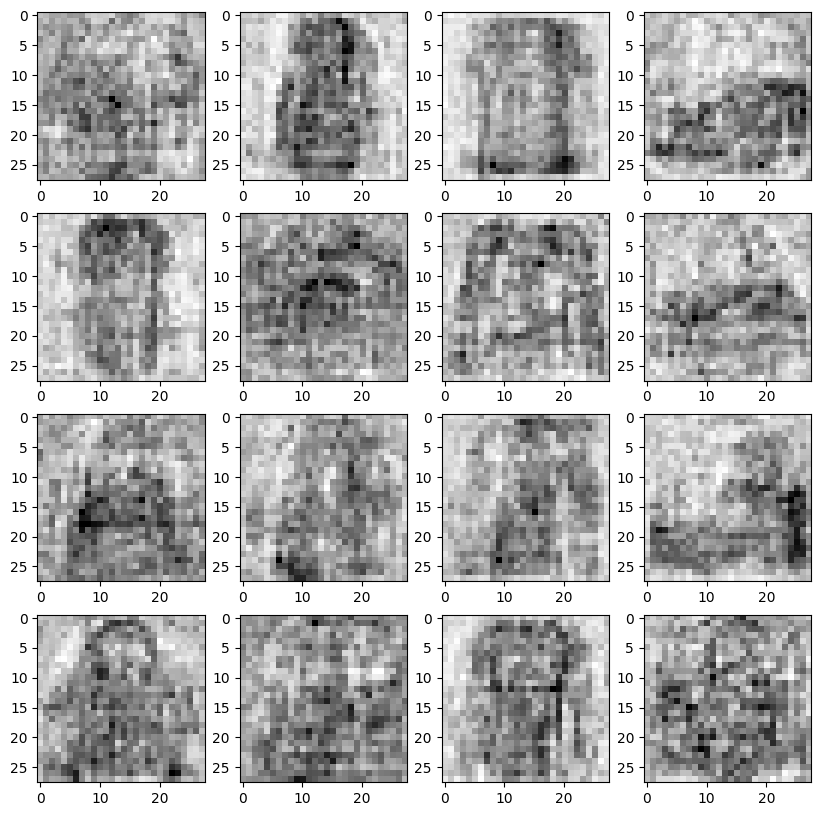

In [11]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for j,img in enumerate(sample_images):
  for i,ax in enumerate(axes.flatten()):
    ax.imshow(img[i], cmap='Greys')

2.399459481239319e-05
1.1179596185684204e-05
-7.9423189163208e-06
-7.966533303260803e-06
-1.365412026643753e-05
1.1030584573745728e-05
-1.2166798114776611e-05
-7.2587281465530396e-06
-1.4925375580787659e-05


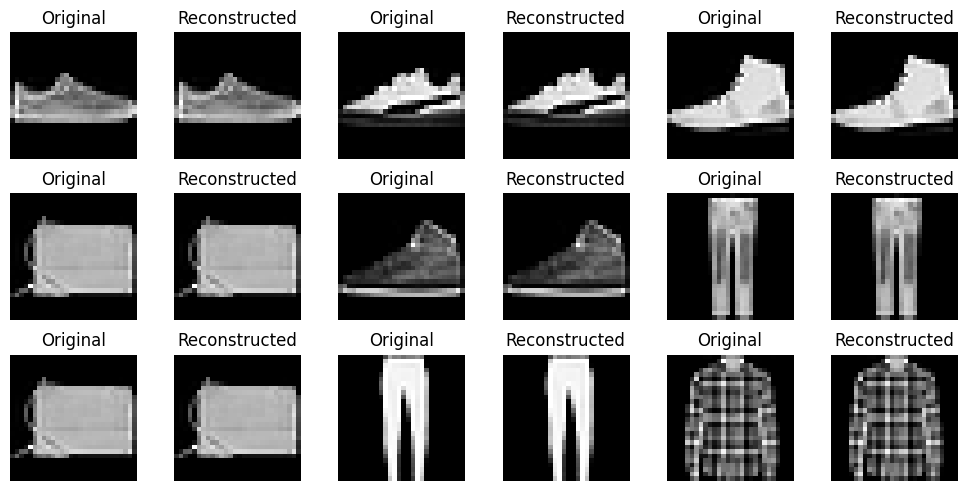

In [15]:
# Demonstrate reconstructed images
demonstrate_x(realnvp, test_loader, device=device)

In [16]:
# Load datasets
fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
mnist = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
cifar10 = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]), download=True)

# Create data loaders
batch_size = 128
fashion_train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=False)
fashion_test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)
mnist_loader = DataLoader(mnist, batch_size=batch_size, shuffle=False)
cifar10_loader = DataLoader(cifar10, batch_size=batch_size, shuffle=False)

# Function to calculate log-likelihoods for a dataset
def calculate_log_likelihoods(model, data_loader, device):
    model.eval()
    all_likelihoods = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            log_probs = model.log_prob(x)
            all_likelihoods.append((log_probs[0] + log_probs[2] + log_probs[2]).cpu().numpy())

    all_likelihoods = np.concatenate(all_likelihoods)
    return np.mean(all_likelihoods), np.var(all_likelihoods)


fashion_train_mean, fashion_train_var = calculate_log_likelihoods(realnvp, fashion_train_loader, device)
fashion_test_mean, fashion_test_var = calculate_log_likelihoods(realnvp, fashion_test_loader, device)
mnist_mean, mnist_var = calculate_log_likelihoods(realnvp, mnist_loader, device)
cifar10_mean, cifar10_var = calculate_log_likelihoods(realnvp, cifar10_loader, device)


print(f"FashionMNIST (Train) - Mean: {fashion_train_mean:.4f}, Variance: {fashion_train_var:.4f}")
print(f"FashionMNIST (Test)  - Mean: {fashion_test_mean:.4f}, Variance: {fashion_test_var:.4f}")
print(f"MNIST               - Mean: {mnist_mean:.4f}, Variance: {mnist_var:.4f}")
print(f"CIFAR-10            - Mean: {cifar10_mean:.4f}, Variance: {cifar10_var:.4f}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.84MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
FashionMNIST (Train) - Mean: -730.6993, Variance: 54.5434
FashionMNIST (Test)  - Mean: -731.6882, Variance: 79.7072
MNIST               - Mean: -751.9948, Variance: 67.0775
CIFAR-10            - Mean: -785.3040, Variance: 3032.1704


In [17]:
# Function to calculate log-likelihoods for a dataset after decoding
def calculate_log_likelihoods(model, data_loader, device):
    model.eval()
    all_likelihoods = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            x, _, _ = model.forward(x)
            log_probs = model.log_prob(x)
            all_likelihoods.append((log_probs[0] + log_probs[2] + log_probs[2]).cpu().numpy())

    all_likelihoods = np.concatenate(all_likelihoods)
    return np.mean(all_likelihoods), np.var(all_likelihoods)

fashion_train_mean, fashion_train_var = calculate_log_likelihoods(realnvp, fashion_train_loader, device)
fashion_test_mean, fashion_test_var = calculate_log_likelihoods(realnvp, fashion_test_loader, device)
mnist_mean, mnist_var = calculate_log_likelihoods(realnvp, mnist_loader, device)
cifar10_mean, cifar10_var = calculate_log_likelihoods(realnvp, cifar10_loader, device)

# Print results
print(f"FashionMNIST (Train) - Mean: {fashion_train_mean:.4f}, Variance: {fashion_train_var:.4f}")
print(f"FashionMNIST (Test)  - Mean: {fashion_test_mean:.4f}, Variance: {fashion_test_var:.4f}")
print(f"MNIST               - Mean: {mnist_mean:.4f}, Variance: {mnist_var:.4f}")
print(f"CIFAR-10            - Mean: {cifar10_mean:.4f}, Variance: {cifar10_var:.4f}")


FashionMNIST (Train) - Mean: -759.0092, Variance: 189.3857
FashionMNIST (Test)  - Mean: -760.7880, Variance: 273.3058
MNIST               - Mean: -794.9692, Variance: 309.1333
CIFAR-10            - Mean: -855.5784, Variance: 9009.1123
